# Demo: Mapping Luhman 16B with NIRSpec

In this tutorial, we will demonstrate how to use `spectralmap` to analyze time-series observations. We will use a sequence of NIRSpec observations of the brown dwarf Luhman 16B to recover a spectroscopic map of its surface.

**We will cover:**
1. Loading and preprocessing the lightcurve data.
2. Inverting the lightcurves to obtain surface maps.
3. Clustering the map pixels to identify distinct spectral regions.
4. Extracting and analyzing the spectra of these regions.

Let's get started!

In [1]:
import numpy as np
print(np.__version__)
np.bool = bool
import starry
starry.config.lazy = False  # disable lazy evaluation
starry.config.quiet = True  # disable warnings
map = starry.Map(ydeg=4)

1.21.1


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,    
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
    "figure.dpi": 300,
    "figure.figsize": (3.5, 2.5),  # ApJ column width ~3.5 in; double column ~7 in
})
import spectralmap
print(f"spectralmap version: {spectralmap.__version__}")

spectralmap version: 0.1.0


## 1. Load Data
We load the NIRSpec lightcurve files. Each file corresponds to a specific rotation phase (angle). We will read them in, sort them by phase, and normalize the flux.

In [3]:
import pandas as pd
from glob import glob
import numpy as np


time_B = np.load("W1049B_NIRSpec_processed.npz")["time_B"]
wl_B = np.load("W1049B_NIRSpec_processed.npz")["wl_B"]
LC_B = np.load("W1049B_NIRSpec_processed.npz")["LC_B"]
LC_B_norm = np.load("W1049B_NIRSpec_processed.npz")["LC_B_norm"]

res = 360
period = 5 # hours
dt = np.diff(time_B).mean() * 24
factor = int(period // (res * dt))

n_groups = len(time_B) // factor
print(f"Number of time bin: {n_groups}")
time_B_binned = np.mean(time_B[:n_groups * factor].reshape(-1, factor), axis=1) # binned in time
LC_B_binned = np.zeros((len(LC_B), n_groups)) # binned in time
for i in range(len(LC_B)):
    LC_B_binned[i] = np.mean(LC_B[i][:n_groups * factor].reshape(-1, factor), axis=1)
# data = LC_B # LC_B_binned
data = LC_B_binned
amplitudes = np.nanmean(data, axis=1)
data_norm = (data.T / amplitudes).T
flux = data_norm
# time = time_B * 24 # time_B_binned * 24
time = time_B_binned * 24
theta = time / period * 360  # degrees

Number of time bin: 519


## 2. Inversion with SpectralMap

First, we organize the data into a `LightCurveData` object. We must specify the inclination of the object (here assumed to be 80 degrees).

In [4]:
np.bool = bool
from spectralmap.mapping import LightCurveData, make_map
data = LightCurveData(theta=theta, flux=flux[:, :], flux_err=None, inc=90)

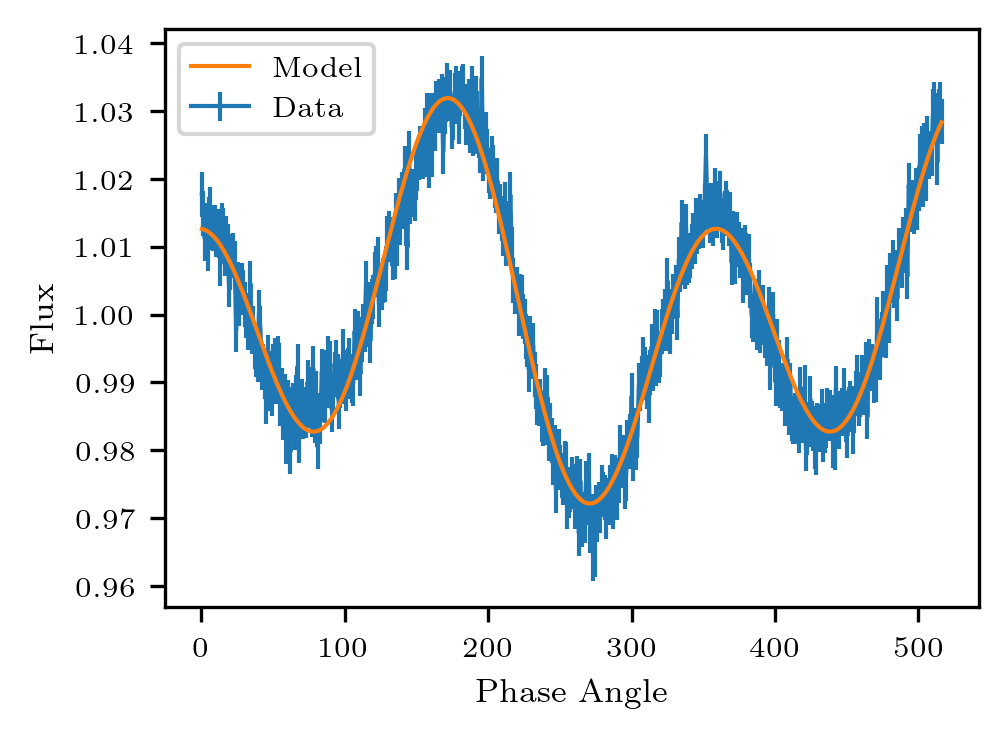

In [5]:
map = make_map(mode='rotational', map_res=30, ydeg=2, inc=90)
map.solve_posterior(data.flux[10], None, data.theta, verbose=False)
map.plot_lightcurve()

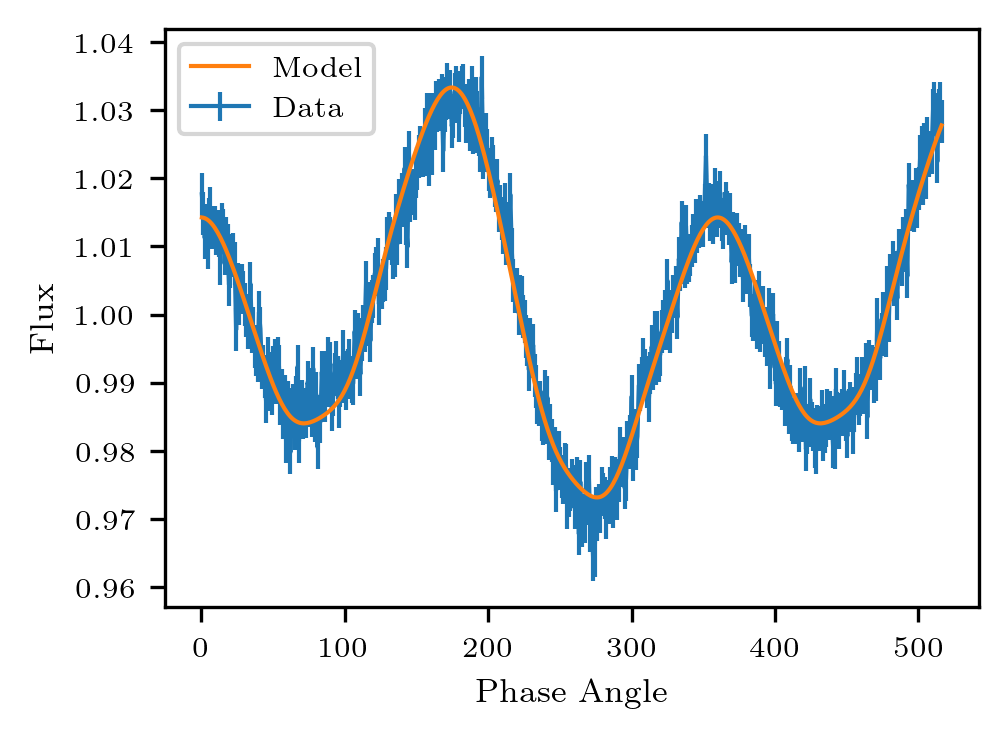

In [6]:
map = make_map(mode='rotational', map_res=30, ydeg=10, inc=90)
map.solve_posterior(data.flux[10], None, data.theta, verbose=False)
map.plot_lightcurve()

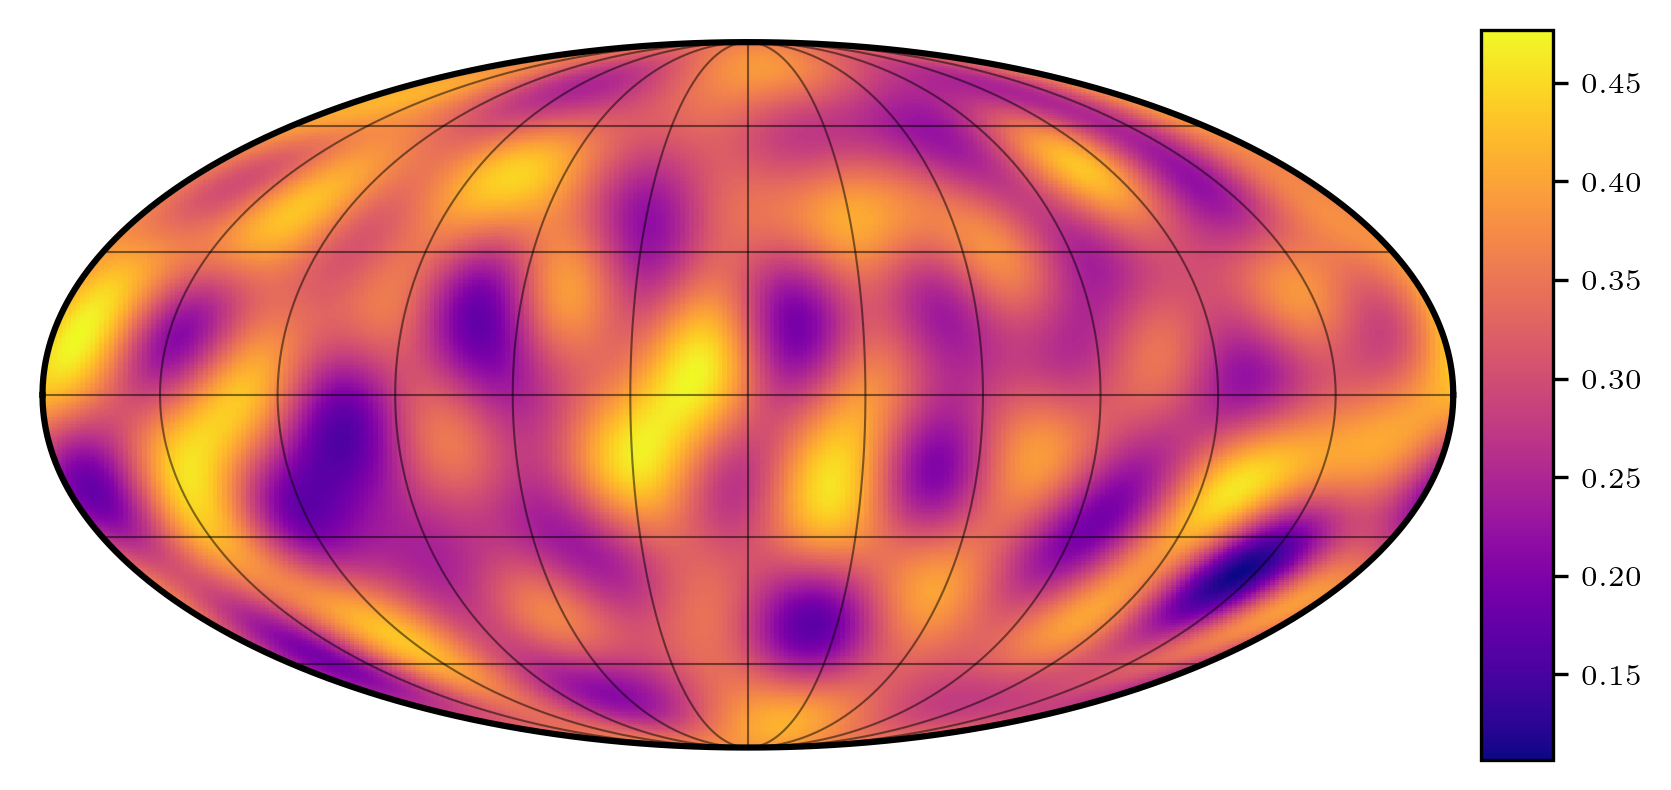

array([[ 1.00000000e+00,  2.18309863e-02, -8.27141790e-03,
        -5.66445737e-03, -2.66263859e-02, -2.13855864e-02,
         4.34004764e-02,  3.81532855e-03, -2.31876085e-02,
         8.92632747e-03,  5.33378696e-03,  5.39771394e-03,
         7.79778316e-03, -2.05523661e-02,  2.34864366e-04,
         2.08402761e-02, -5.88218157e-03,  1.53640511e-03,
         1.49441983e-02, -1.56863618e-02,  1.31873391e-02,
        -1.69307261e-02,  2.76179605e-02, -2.33867228e-02,
        -2.02123376e-02,  3.85373290e-03,  1.08693393e-02,
        -3.21795882e-02, -5.59897293e-03, -5.89247494e-03,
         2.74469077e-03, -5.81800246e-03,  2.81776495e-03,
        -4.99059607e-03, -2.03583304e-03, -2.63481334e-03,
        -4.42669238e-03, -1.35870983e-02, -1.47057834e-02,
         1.26483679e-02, -4.73397452e-03, -2.53684185e-02,
        -4.80462273e-03, -2.48290020e-02,  1.48307609e-02,
        -1.62685755e-02, -5.71454172e-03,  8.00955503e-03,
        -1.24974256e-03, -1.74657655e-02,  2.56852465e-0

In [7]:
map.draw(plot=True, projection="moll", grid=True, colorbar=True, n_samples=1)

In [8]:
map.design_matrix_.shape

(519, 121)

### Find Optimal Map Complexity
We now solve for the maps. Since we don't know the complexity of the surface beforehand, we test spherical harmonic degrees ranging from `ydeg=2` to `ydeg=10`. The algorithm will automatically select the degree that best fits the data without overfitting (using the Bayesian Information Criterion).

In [9]:
from spectralmap.mapping import make_maps
maps = make_maps(mode='rotational', map_res=30, ydegs=np.arange(2, 7))

In [10]:
# Solve for the best spherical harmonic degree (ydeg) for each wavelength
# This optimizes the model complexity (model evidence) to avoid overfitting
w_all, I_all_wl, I_cov_all_wl = maps.marginalized_maps(data)

print("Best Spherical Harmonic Degree per wavelength bin:")
print(w_all)

Fitting ydeg=2...
  Wavelength 1/334...
Hyperparameter optimization converged after 13 iterations.
Final hyperparameters: alpha=2647.893337873184, beta=3004.226643105273, lambda_fix=disabled
Optimized hyperparameters: 2647.893337873184, beta=3004.226643105273, lambda_fix=disabled, log_ev=1329.5692312919537, log_ev_marginalized=1328.1803091498077
  Wavelength 2/334...
Hyperparameter optimization converged after 13 iterations.
Final hyperparameters: alpha=2752.2735552779286, beta=6670.675676512243, lambda_fix=disabled
Optimized hyperparameters: 2752.2735552779286, beta=6670.675676512243, lambda_fix=disabled, log_ev=1534.6752511222755, log_ev_marginalized=1533.283216378563
  Wavelength 3/334...
Hyperparameter optimization converged after 13 iterations.
Final hyperparameters: alpha=2584.9106421139977, beta=10771.393750321899, lambda_fix=disabled
Optimized hyperparameters: 2584.9106421139977, beta=10771.393750321899, lambda_fix=disabled, log_ev=1657.665847248206, log_ev_marginalized=1656.27

## 3. Visualize the Maps
Let's take a look at the recovered maps for a few wavelengths to see how the surface features change.

In [11]:
# for i, ydeg in enumerate(ydeg_best[:10]):
#     if ydeg <= 5:
#         plt.figure()
#         plt.imshow(I_all_wl[i].reshape((30, 30)), origin='lower')
#         plt.title(f"Wavelength {wl_B[i]: .2f}: best ydeg = {ydeg}")

## 4. Spectral Extraction
We convert the retrieved intensity maps ($I$) back into physical flux units ($F$) and calculate the associated variances. This gives us the spatially-resolved spectra.

In [12]:
F_all_wl = I_all_wl * amplitudes[:, None] *np.pi
F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)

In [13]:
from spectralmap.mapping import expand_moll_values
F_all_wl_grid = expand_moll_values(F_all_wl, maps.moll_mask_flat)
F_var_all_wl_grid = expand_moll_values(F_var_all_wl, maps.moll_mask_flat)

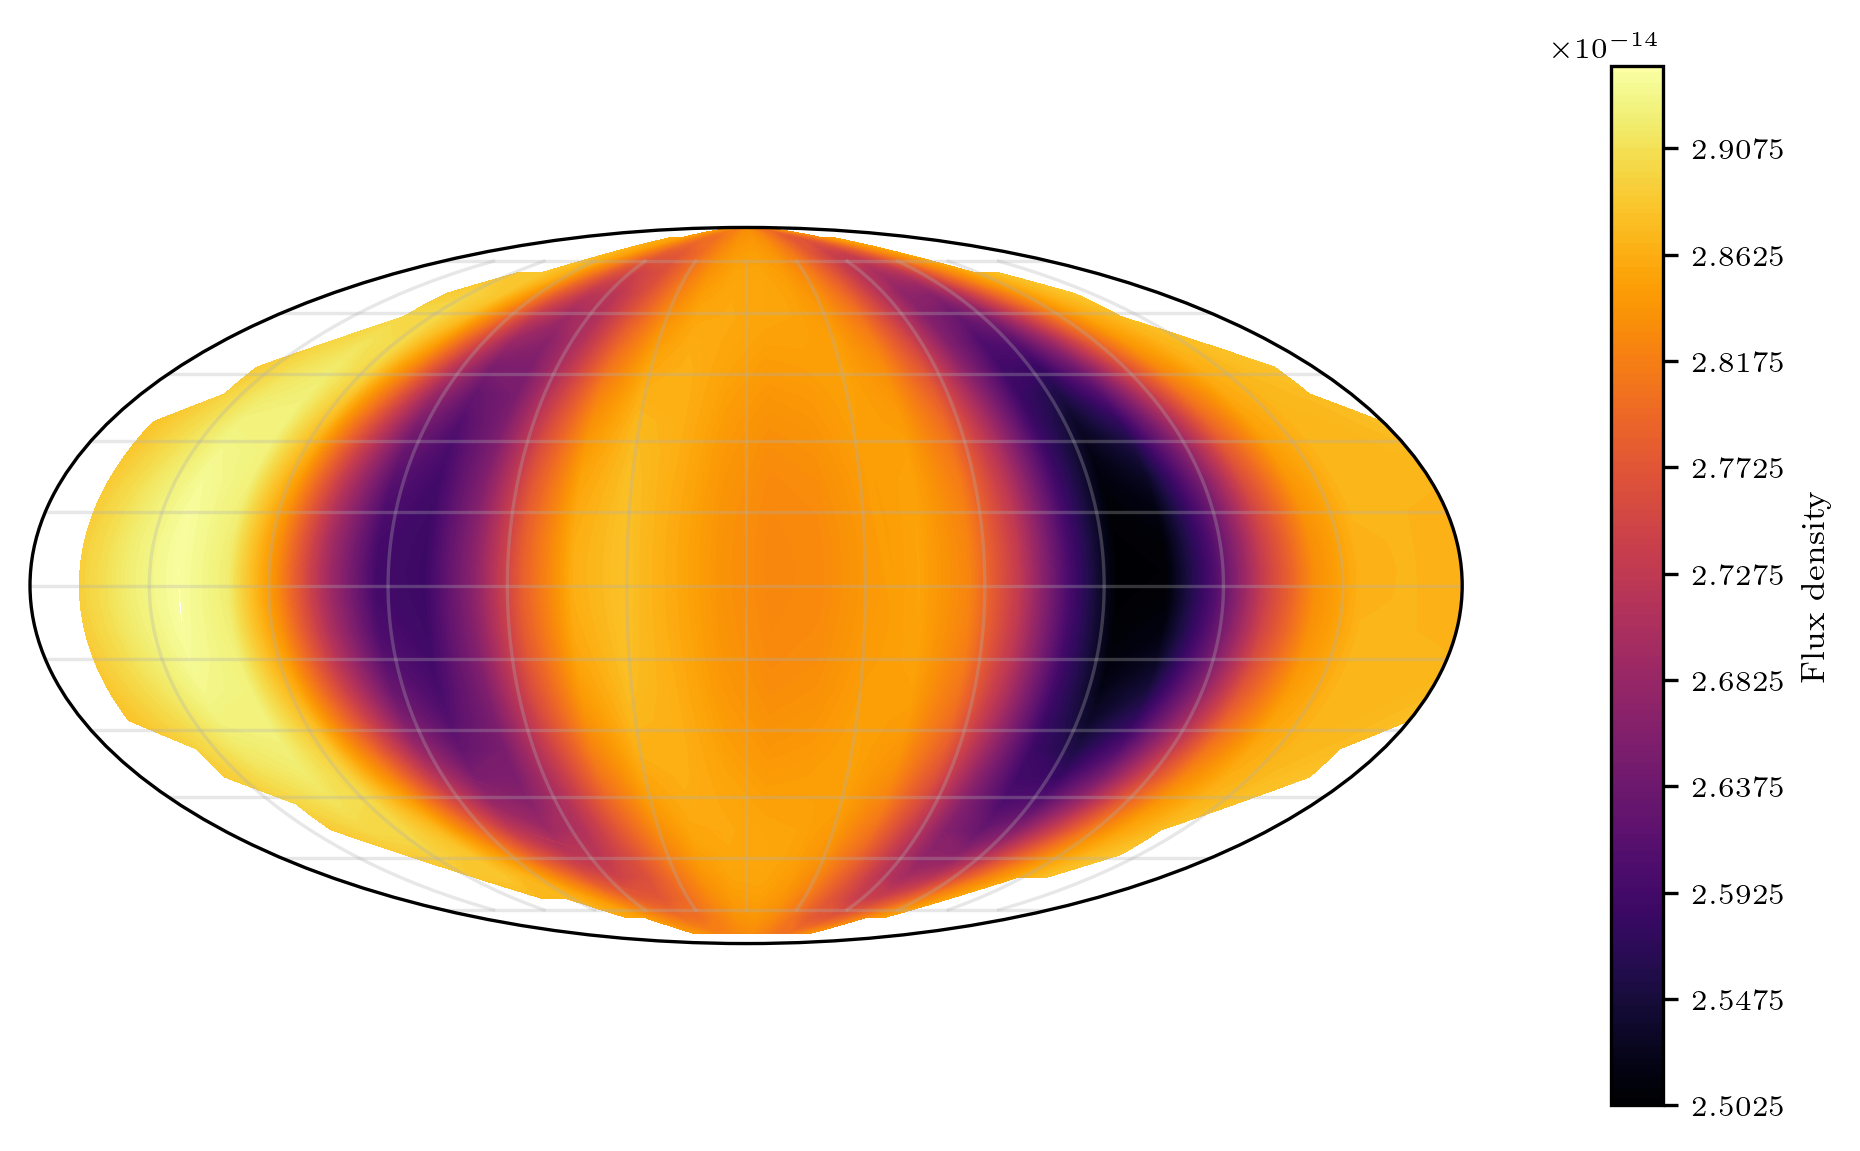

In [27]:
from spectralmap.utilities import plot_mollweide_projection

fig, ax, pcm, cb = plot_mollweide_projection(
    values_by_wavelength=np.mean(F_all_wl, axis=0),
    moll_mask=maps.moll_mask,
    map_res=maps.map_res,
    cbar_label="Flux density",
    cmap="inferno",
    levels=200,
    smooth_boundary=False,
    hide_ticks=True,
    show_grid=True,
)
plt.show()

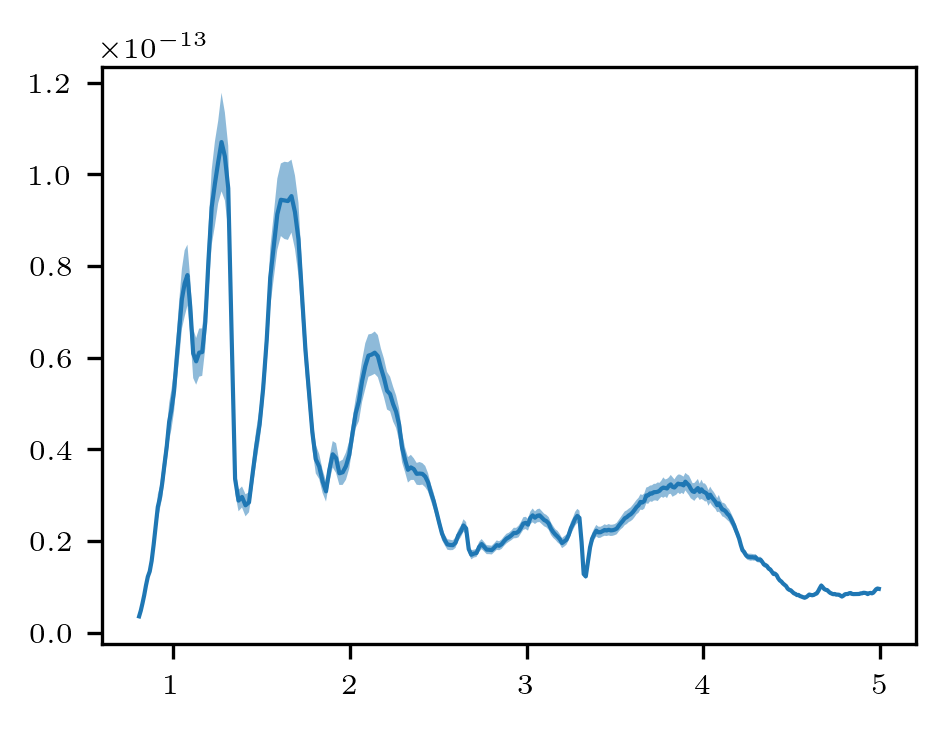

In [15]:
import matplotlib.pyplot as plt
i_grid = -1
plt.plot(wl_B[:], F_all_wl[:, i_grid])
plt.fill_between(wl_B[:], F_all_wl[:, i_grid] - np.sqrt(F_var_all_wl[:, i_grid]), F_all_wl[:, i_grid] + np.sqrt(F_var_all_wl[:, i_grid]), alpha=0.5)

## 5. Clustering and Regional Identification
To make sense of the map, we group pixels that show similar spectral behavior using a clustering algorithm. This helps us identify distinct "regions" or features on the object's surface.

Step 1 (Corners: 11): Loss 4 vs Prev 2 (Ratio: 2.0)
Step 2 (Corners: 10): Loss 4 vs Prev 4 (Ratio: 1.0)
Step 3 (Corners: 9): Loss 10 vs Prev 4 (Ratio: 2.5)
Step 4 (Corners: 8): Loss 12 vs Prev 10 (Ratio: 1.2)
Step 5 (Corners: 7): Loss 13 vs Prev 12 (Ratio: 1.1)
Step 6 (Corners: 6): Loss 24 vs Prev 13 (Ratio: 1.8)
Step 7 (Corners: 5): Loss 48 vs Prev 24 (Ratio: 2.0)
Step 8 (Corners: 4): Loss 79 vs Prev 48 (Ratio: 1.6)
Step 9 (Corners: 3): Loss inf vs Prev 79 (Ratio: inf)
-> Elbow detected at 3 corners!
-1 399
0 79
1 100
2 121


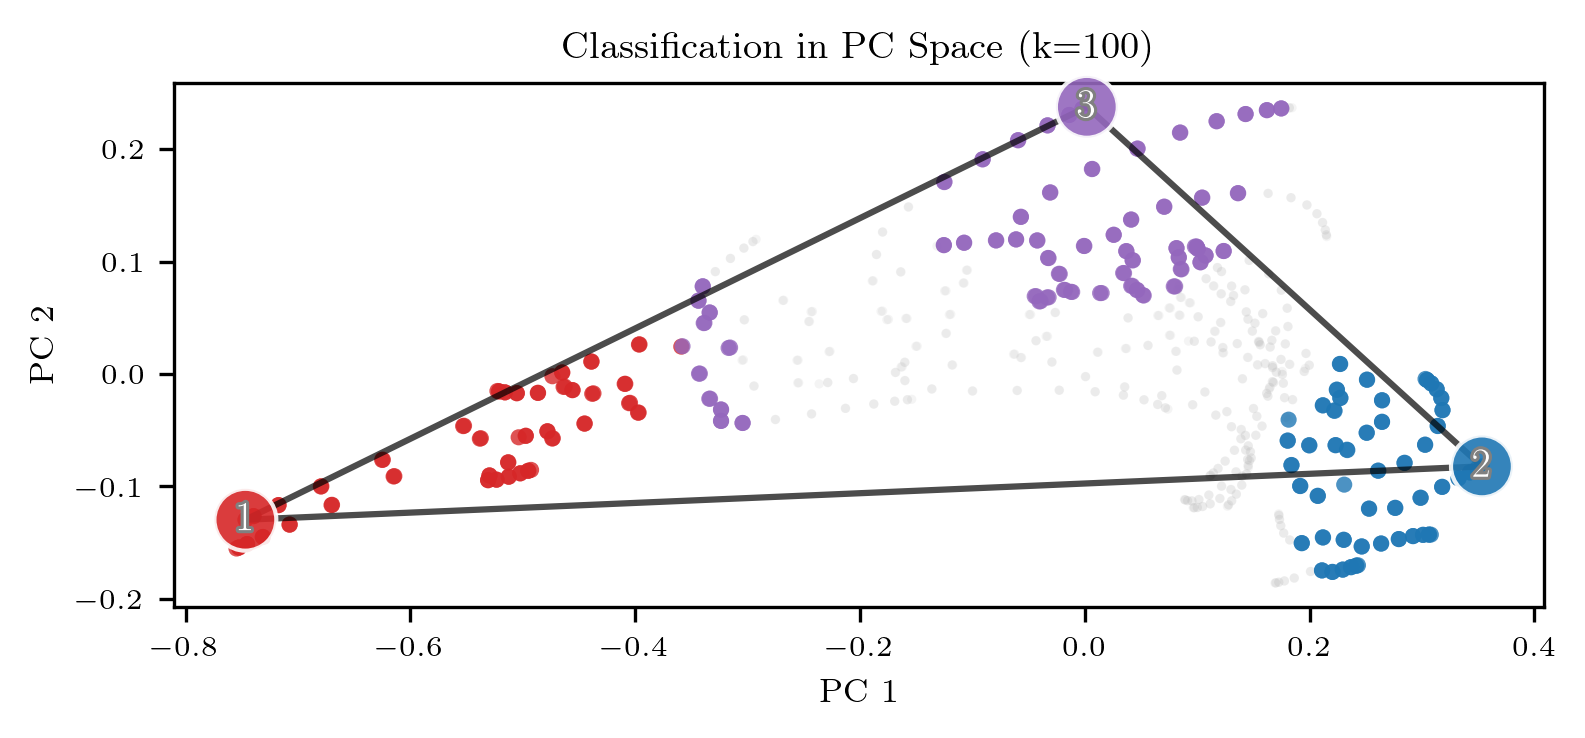

In [43]:
from spectralmap.cluster import find_clusters
F_regionals, F_regional_errs, labels = find_clusters(F_all_wl, F_cov_all_wl, n_neighbors=100, sensitivity=5)
N = len(F_regionals)

## 6. Results
Finally, we visualize the identified clusters on the map and plot the mean spectrum for each region.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.ndimage import zoom, distance_transform_edt

def plot_mollweide_rgb_perfect_edges(pc1_scores, pc2_scores, mask_2d, labels, upsample=4):
    mask_2d = np.asarray(mask_2d, dtype=bool)
    H, W = mask_2d.shape
    
    # 1. Safely normalize to [0, 1]
    def norm_01(x):
        x = np.nan_to_num(x)
        vmin, vmax = x.min(), x.max()
        if vmin == vmax: 
            return np.zeros_like(x)
        return (x - vmin) / (vmax - vmin)
    
    r_val = norm_01(pc1_scores)
    b_val = norm_01(pc2_scores)
    
    # 2. Fill baseline channels
    R = np.zeros((H, W))
    G = np.full((H, W), 0.15) # Baseline green so it's never pure black
    B = np.zeros((H, W))
    
    R[mask_2d] = r_val
    B[mask_2d] = b_val
    
    # --- 3. Extrapolate colors to fill the ENTIRE rectangle ---
    # We flood the empty space with the nearest valid colors.
    invalid = ~mask_2d
    if np.any(invalid):
        # Finds the row/col indices of the nearest valid pixel (where invalid == 0)
        nearest_idx = distance_transform_edt(invalid, return_distances=False, return_indices=True)
        R[invalid] = R[nearest_idx[0, invalid], nearest_idx[1, invalid]]
        G[invalid] = G[nearest_idx[0, invalid], nearest_idx[1, invalid]]
        B[invalid] = B[nearest_idx[0, invalid], nearest_idx[1, invalid]]

    # --- 4. Smooth the filled color channels ---
    # order=3 is bicubic (smoother than bilinear). Clip to keep RGB in bounds.
    R_sm = np.clip(zoom(R, upsample, order=3), 0.0, 1.0)
    G_sm = np.clip(zoom(G, upsample, order=3), 0.0, 1.0)
    B_sm = np.clip(zoom(B, upsample, order=3), 0.0, 1.0)
    
    # Set Alpha to 1.0 EVERYWHERE. Matplotlib's axis will naturally clip the map into an ellipse.
    A_sm = np.ones_like(R_sm)
    
    # 5. Coordinate Grid
    H_new, W_new = R_sm.shape
    lon_edges = np.linspace(-np.pi, np.pi, W_new + 1)
    lat_edges = np.linspace(-np.pi/2, np.pi/2, H_new + 1)
    Lon, Lat = np.meshgrid(lon_edges, lat_edges)
    
    # Flatten colors
    rgba_colors = np.dstack((R_sm, G_sm, B_sm, A_sm)).reshape(-1, 4)
    
    # 6. Plotting
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='mollweide')
    
    dummy_data = np.zeros((H_new, W_new))
    mesh = ax.pcolormesh(
        Lon, Lat, dummy_data, 
        shading='flat', 
        zorder=2
    )
    
    mesh.set_array(None)              
    mesh.set_facecolors(rgba_colors)  
    mesh.set_edgecolors('none')       
    
    ax.grid(True, alpha=0.3, linewidth=0.5, zorder=3)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    legend_elements = [
        Patch(facecolor=(1.0, 0.15, 0.0), label='High PC1 (Red)'),
        Patch(facecolor=(0.0, 0.15, 1.0), label='High PC2 (Blue)'),
        Patch(facecolor=(1.0, 0.15, 1.0), label='High Both (Magenta)')
    ]
    ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
    ax.set_title("PC1 and PC2 Overlay (Seamless Edge)", pad=15)
    # --- Add this right before setting up the legend and returning ---

    # 1. Create a grid for the pixel CENTERS (contour needs centers, pcolormesh needs edges)
    
    # 2. Define levels halfway between integer labels to trace the exact borders
    # Assuming labels are integers (0, 1, 2, 3...)
    min_label = int(np.nanmin(labels))
    max_label = int(np.nanmax(labels))
    boundary_levels = np.arange(min_label, max_label + 1) + 0.5
    # 1. Create a grid for the pixel CENTERS (contour needs centers, pcolormesh needs edges)
    # Using the original map_res dimensions, not the upsampled ones
    lon_centers = np.linspace(-np.pi, np.pi, 30)
    lat_centers = np.linspace(-np.pi/2, np.pi/2, 30)
    Lon_c, Lat_c = np.meshgrid(lon_centers, lat_centers)
    # 3. Draw the contours
    ax.contour(
        Lon_c, Lat_c, labels, 
        levels=boundary_levels, 
        colors='white',       # White stands out nicely against the dark PCA colors
        linewidths=1.2,       # Adjust thickness as needed
        zorder=4,             # Ensures it sits on top of the map and grid
        alpha=0.9             # Slight transparency so it doesn't completely blind the data
    )

    return fig, ax

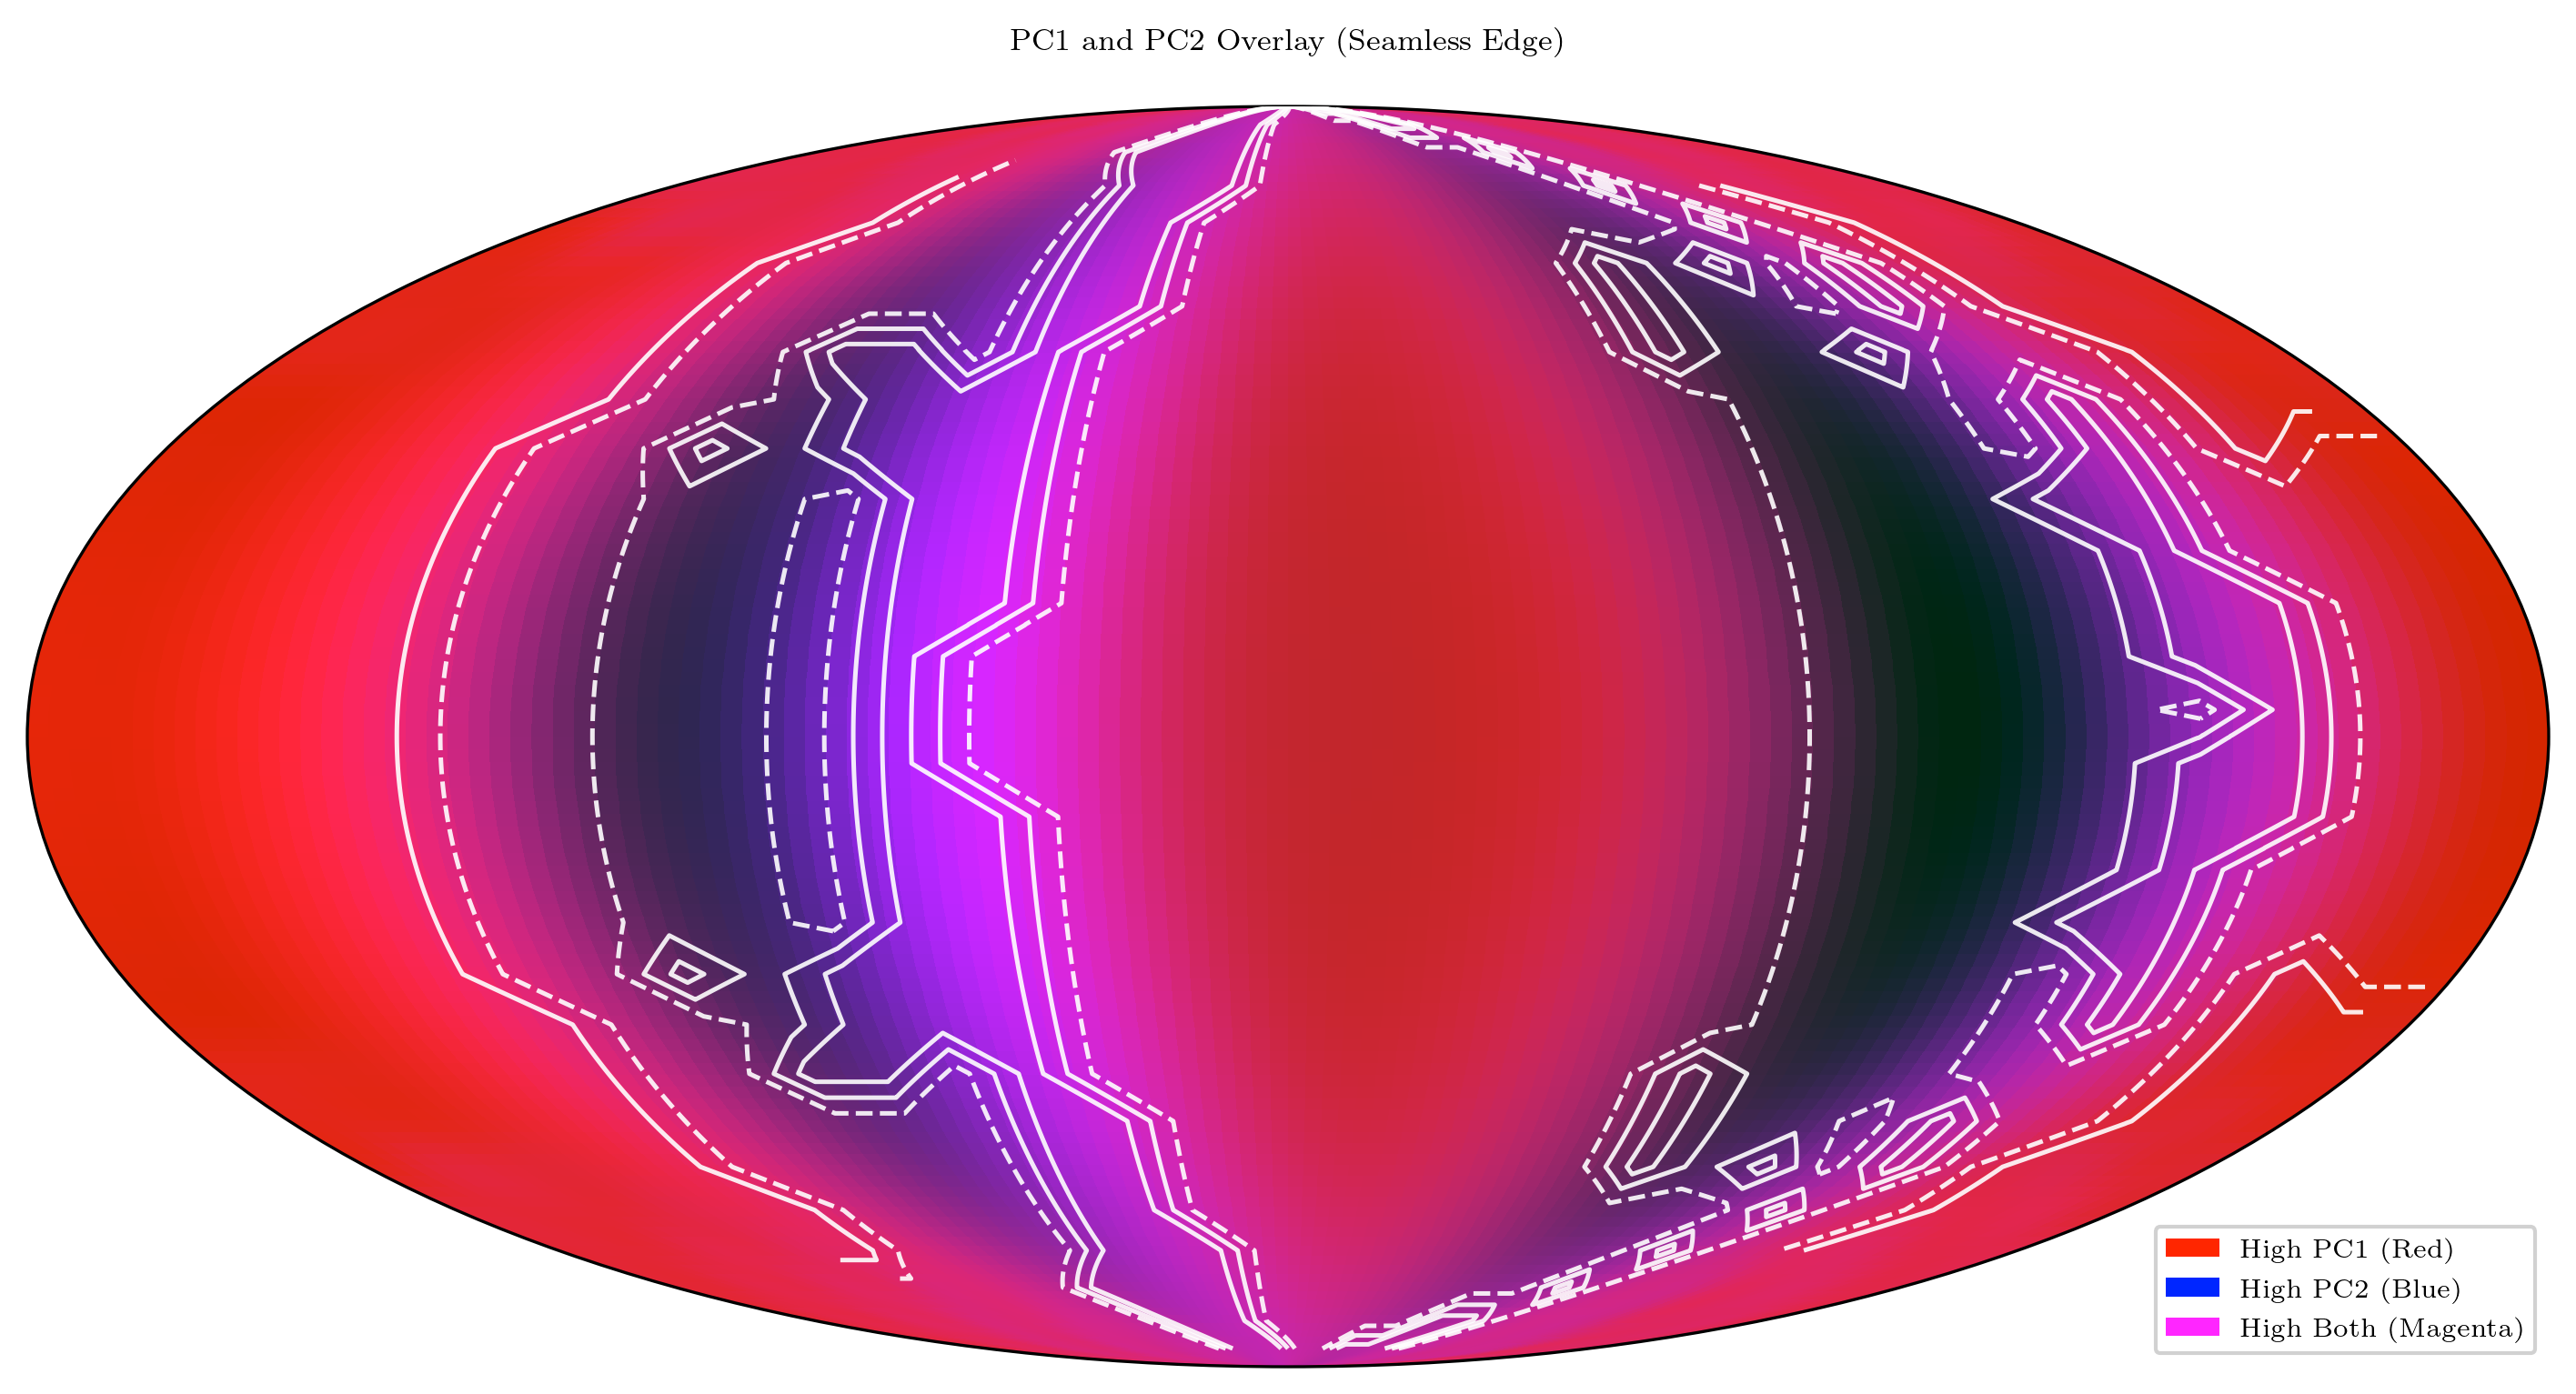

In [42]:
from sklearn.decomposition import PCA
from spectralmap.utilities import expand_moll_values
pca = PCA(n_components=2)
PCs = pca.fit_transform(np.log(F_all_wl).T)  # shape: (n_wavelengths, 2)
pc1_scores = PCs[:, 0]
pc2_scores = PCs[:, 1]

mask_2d = maps.moll_mask
fig, ax = plot_mollweide_rgb_perfect_edges(pc1_scores, pc2_scores, mask_2d, labels=expand_moll_values(labels, maps.moll_mask).reshape(mask_2d.shape), upsample=4)
plt.show()

In [18]:
full = expand_moll_values(labels, maps.moll_mask)
full.shape

(900,)

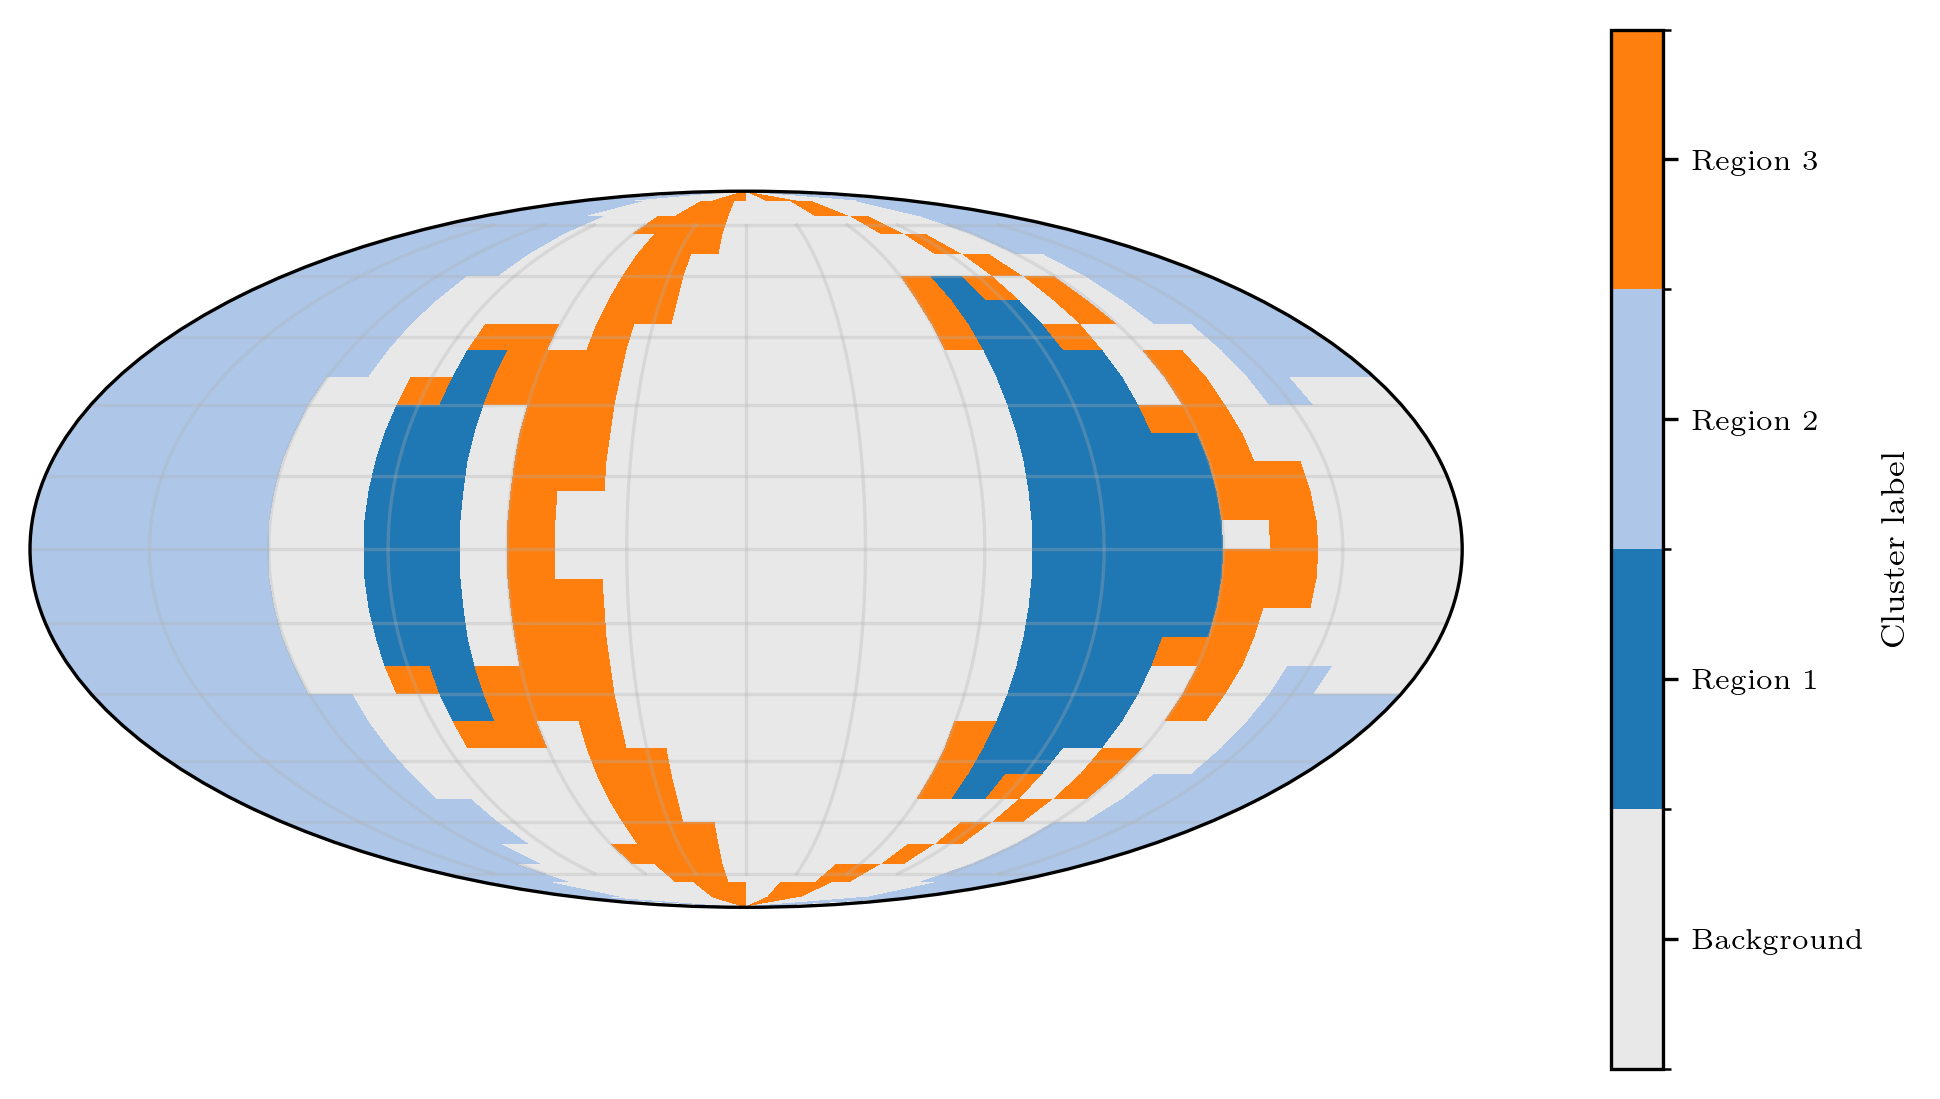

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy.ndimage import gaussian_filter, distance_transform_edt
def plot_mollweide_labels(
    labels_masked,          # (n_valid_pix,) or (map_res*map_res,) if already full
    moll_mask,              # full-grid mask, shape (map_res,map_res) or flat
    map_res=None,
    cmap=None,
    names=None,
    ax=None,
    show_grid=True,
    hide_ticks=True,
):
    moll_mask = np.asarray(moll_mask, dtype=bool)
    if map_res is None:
        map_res = moll_mask.shape[0] if moll_mask.ndim == 2 else int(np.sqrt(moll_mask.size))
    mask_flat = moll_mask.ravel()

    # Expand masked labels back to full grid
    full = np.full(mask_flat.size, np.nan)
    labels_masked = np.asarray(labels_masked)
    if labels_masked.size == mask_flat.sum():
        full[mask_flat] = labels_masked
    elif labels_masked.size == mask_flat.size:
        full[:] = labels_masked
    else:
        raise ValueError("labels size must match mask.sum() or mask.size")

    img = full.reshape(map_res, map_res)

    # lon/lat edges for pcolormesh (edges, not centers)
    lon_edges = np.linspace(-np.pi, np.pi, map_res + 1)
    lat_edges = np.linspace(-0.5 * np.pi, 0.5 * np.pi, map_res + 1)
    lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

    if ax is None:
        fig = plt.figure(figsize=(8, 4.5))
        ax = fig.add_subplot(111, projection="mollweide")
    else:
        fig = ax.figure

    # Discrete norm: bins centered on integers
    # valid labels are assumed to be integers -1..K-1
    finite = np.isfinite(img)
    if not np.any(finite):
        raise ValueError("No finite labels to plot.")
    K = int(np.nanmax(img)) + 1
    
    if cmap is None:
        cmap = plt.get_cmap("tab20", K)

    bounds = np.arange(-1.5, K + 0.5, 1.0)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Mask outside footprint: keep it transparent (no smearing)
    nearest_idx = distance_transform_edt(~finite, return_distances=False, return_indices=True)
    filled = img.copy()
    filled[~finite] = filled[tuple(nearest_idx[:, ~finite])]
    
    pcm = ax.pcolormesh(
        lon2d, lat2d, filled,
        cmap=cmap, norm=norm,
        shading="flat",   # crisp pixels
        antialiased=False # reduces edge halos
    )

    if show_grid:
        ax.grid(True, alpha=0.3)

    cb = fig.colorbar(pcm, ax=ax, pad=0.08)
    cb.set_label("Cluster label")

    # Put ticks at integer centers
    cb.set_ticks(np.arange(K+1)-1)
    if names is not None:
        cb.set_ticklabels(names)

    if hide_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    return fig, ax, pcm, cb
from matplotlib import colors as mcolors

colors_list = ['#E8E8E8']  # Background
region_colors = plt.get_cmap('tab20').colors
for i in range(N - 1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N - 1)]
cmap = mcolors.ListedColormap(colors_list)

fig, ax, pcm, cb = plot_mollweide_labels(
    labels_masked=labels,      # should be ints 0..N-1 on masked pixels
    moll_mask=maps.moll_mask,
    map_res=map.map_res,
    cmap=cmap,
    names=cluster_names,
)
plt.show()

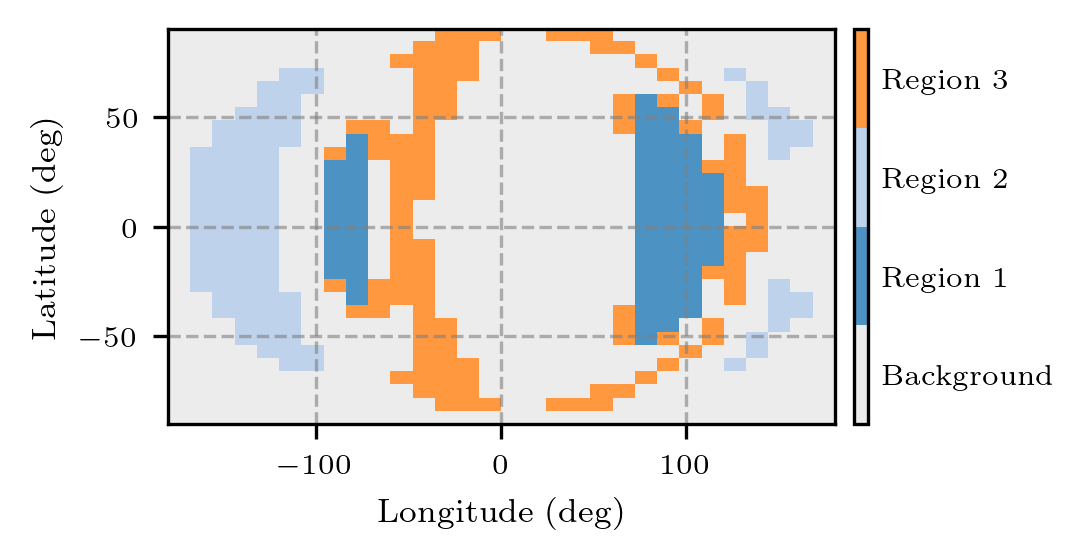

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

# --- 1. SETUP ---
# Rebuild full map grid from masked labels
moll_mask = maps.moll_mask_flat
if np.asarray(moll_mask).ndim == 2:
    mask2d = np.asarray(moll_mask, dtype=bool)
    map_res = mask2d.shape[0]
else:
    map_res = int(np.sqrt(np.asarray(moll_mask).size))
    mask2d = np.asarray(moll_mask, dtype=bool).reshape(map_res, map_res)

labels_full = np.full(mask2d.size, -1.0, dtype=np.float64)  # -1 = background/outside footprint
labels_full[mask2d.ravel()] = np.asarray(labels, dtype=np.float64)
labels_assigned = labels_full.reshape(map_res, map_res).T

# --- 2. STYLE DEFINITIONS ---
colors_list = ['#E8E8E8']  # Light gray for background
region_colors = plt.get_cmap('tab20').colors

for i in range(N - 1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N - 1)]
cmap = mcolors.ListedColormap(colors_list)

# --- 3. PLOTTING ---
fig, ax = plt.subplots(figsize=(3.5, 3.5 * (180 / 360)), dpi=300, constrained_layout=True)

im = ax.imshow(
    labels_assigned.T,
    origin='lower',
    cmap=cmap,
    vmin=-1.5, vmax=N-1.5,
    extent=[-180, 180, -90, 90],
    alpha=0.8,
    aspect='auto'
)

ax.grid(True, linestyle='--', color='gray', alpha=0.6)
ax.set_ylabel("Latitude (deg)", fontsize=8)
ax.set_xlabel("Longitude (deg)", fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=7)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.03, aspect=30)
cbar.set_ticks(np.arange(N)-1)
cbar.ax.set_yticklabels(cluster_names, fontsize=7)
cbar.ax.yaxis.set_tick_params(length=0)
cbar.outline.set_edgecolor('black')

output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "S0136_recovered_regions.pdf")
plt.savefig(output_path, dpi=300)

Plot saved to paper_plots/S0136_recovered_spectra.pdf


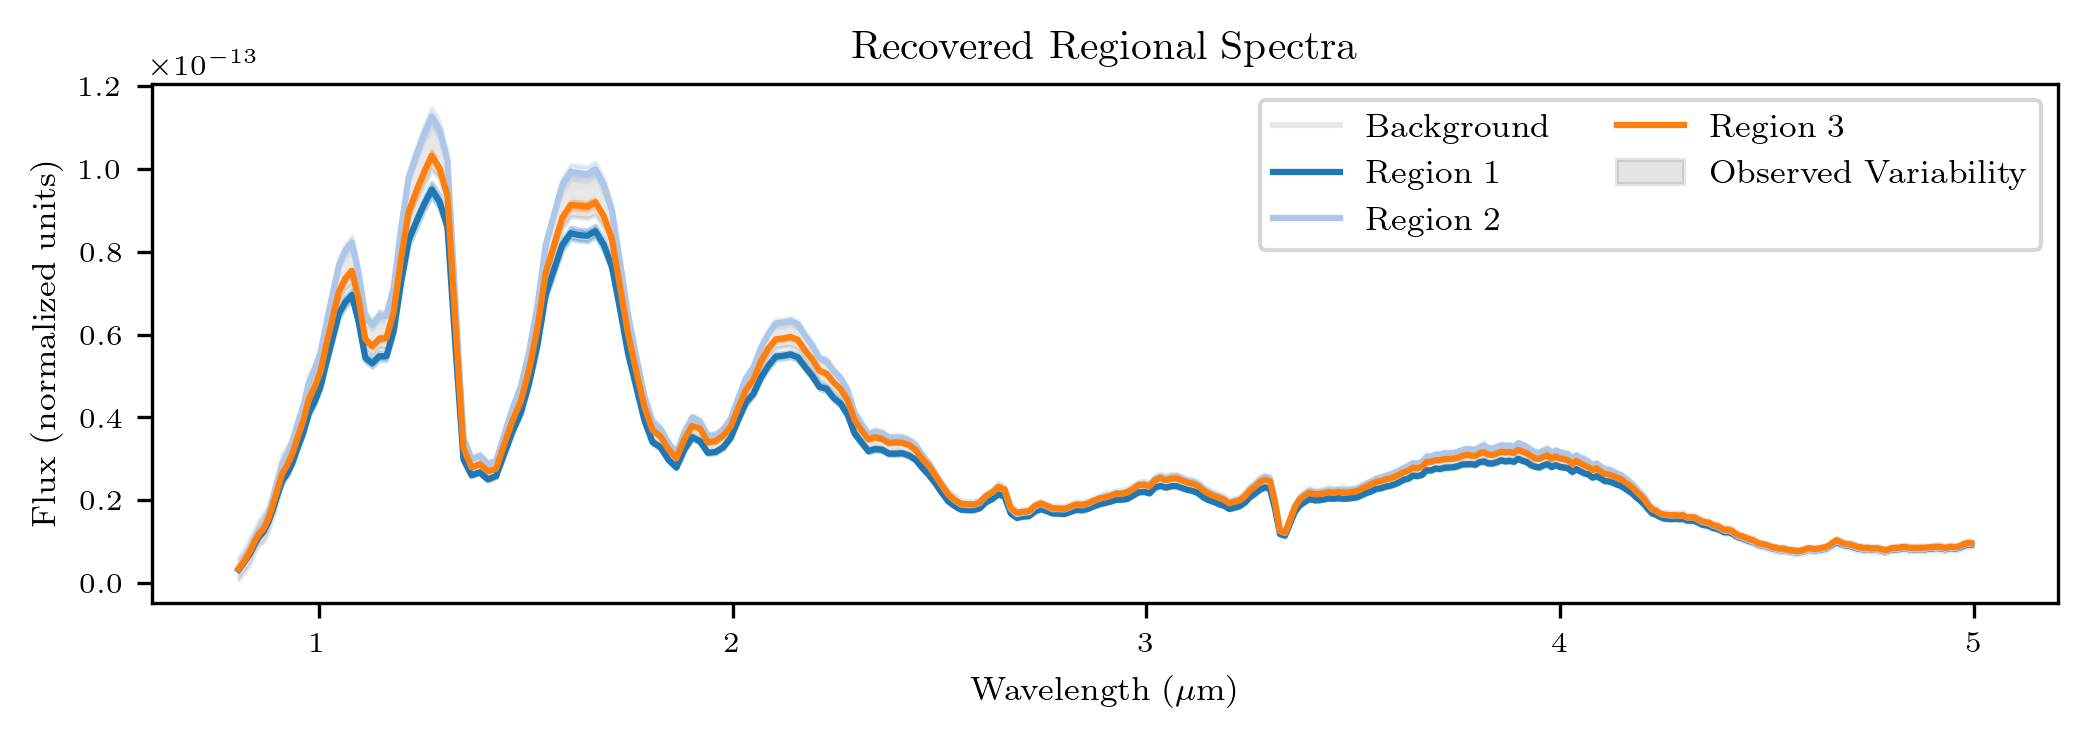

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import os

fig, ax = plt.subplots(figsize=(7, 2.5))

# Plot the recovered spectra for each region
for i in range(N):
    mean_flux = F_regionals[i]
    error_flux = F_regional_errs[i] # Fixed variable name
    color = colors_list[i]
    label = cluster_names[i]
    
    ax.plot(wl_B, mean_flux, label=f"{label}", color=color, linewidth=1.5)
    ax.fill_between(wl_B, 
                    mean_flux - error_flux, 
                    mean_flux + error_flux, 
                    alpha=0.3, color=color)
    
# Overlay the range of the observed time-series variability
time_series = np.sort(LC_B.T, axis=0)
ax.fill_between(wl_B, time_series[0, :],
            time_series[-1, :], color='black', alpha=0.1, zorder=0, label="Observed Variability")

# Formatting
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel("Flux (normalized units)")
ax.set_title("Recovered Regional Spectra", fontsize=10)
ax.legend(fontsize=8, loc='upper right', ncol=2)

plt.tight_layout()

output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "S0136_recovered_spectra.pdf")
plt.savefig(output_path, dpi=600)
print(f"Plot saved to {output_path}")

plt.show()